In [ ]:
import numpy as np
import polars as pl
import geopandas as gpd
import xarray as xr
import rioxarray

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


In [ ]:
RAIN_COL = "rain_mm"

EASTING_RANGE = [276000, 320500] ## based on data I have
NORTHING_RANGE = [258000, 301500] ## based on data I have

# Load data

## Load CEH-GEAR

In [ ]:
ceh_plynlimon = xr.open_dataset('../../../CEH_GEAR/ceh_1km_plynlimonregion_19760101_20101231.nc')
ceh_plynlimon = ceh_plynlimon.rename({'rainfall_amount': RAIN_COL})

## Load HadUK-Grid

In [ ]:
haduk_plynlimon = xr.open_mfdataset(['../../../HadUK_Grid/haduk_grid_1km_day/hadukgrid_1km_plynlimonregion_19760101_19920831.nc',\
                 '../../../HadUK_Grid/haduk_grid_1km_day/hadukgrid_1km_plynlimonregion_19920901_20091231.nc'])
haduk_plynlimon = haduk_plynlimon.rename({'rainfall': RAIN_COL, 'projection_x_coordinate': 'x', 'projection_y_coordinate': 'y'})
haduk_plynlimon = haduk_plynlimon.drop_vars(('latitude', 'longitude'))
haduk_plynlimon['time'] = haduk_plynlimon['time'].dt.floor(freq='D')

## Load HGHT grid

In [ ]:
severn_hght = rioxarray.open_rasterio('../../../Spatial Data/HGHT_SEVERN_1km_CEHGrid.tif')
severn_hght = severn_hght.sortby('y')
severn_hght = severn_hght.sel(band=1)

severn_hght = severn_hght.sel(x=slice(*EASTING_RANGE), y=slice(*NORTHING_RANGE))

## Load gauge metadata

In [ ]:
## monthly gauges
plynlimon_monthly_gauges = pl.read_csv('../gauge_data/mo_monthly_gauges_plynlimon.csv', try_parse_dates=True)

In [ ]:
# daily metadata
plynlimon_metadata = pl.read_csv('../gauge_data/mo_plynlimon_area_metadata.csv')
plynlimon_metadata = plynlimon_metadata.with_columns(
    pl.col("ID").is_in(plynlimon_monthly_gauges['ID']).alias('IS_MONTHLY_GAUGE')
)

In [ ]:
## Load gauge data (QC'd version)
plynlimon_all_gauges = pl.read_csv('../gauge_data/mo_daily_plynlimon_gauges.csv', try_parse_dates=True, new_columns=["gauge_id", "time", f'{RAIN_COL}_gauge', "mo_flag"])

# Load shapefiles (optional)

In [ ]:
plynlimon_shp = gpd.read_file('../plynlimon_catchment_boundary/54022/54022.shp')
bewdley_shp = gpd.read_file('../../FDRI-catchment-contribution-to-floods/River Severn/Catchment_Data/Bewdley/54001/54001.shp')

# Shift grid

In [ ]:
def coerse_data_into_haduk_format(data, offset, xrange, yrange):
    """
    Quick fix for coersing data to have same grid as HADUK.
    """
    data = data.assign_coords(x=(data['x'] + offset))
    data = data.assign_coords(y=(data['y'] + offset))
    data = data.sel(x=xrange, y=yrange)
    return data


In [ ]:
ceh_plynlimon_shifted = coerse_data_into_haduk_format(ceh_plynlimon, offset=500, xrange=slice(*EASTING_RANGE), yrange=slice(*NORTHING_RANGE))

In [ ]:
ceh_plynlimon_shifted['hght'] = severn_hght

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

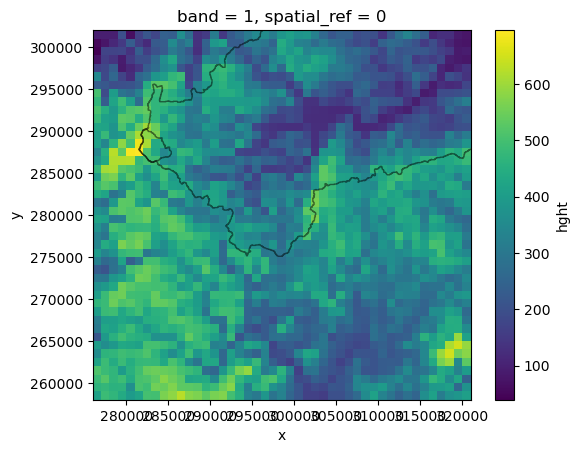

In [ ]:
fig, ax = plt.subplots(1)
(ceh_plynlimon_shifted['hght']/10).plot(ax=ax)
plynlimon_shp.plot(ax=ax, facecolor='none', alpha=.5)
bewdley_shp.plot(ax=ax, facecolor='none', alpha=.5)

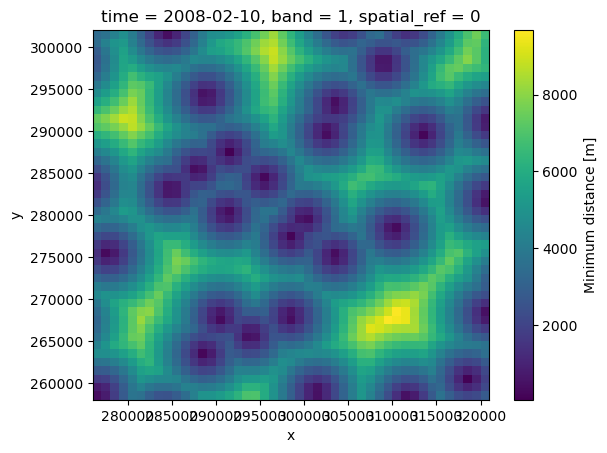

In [ ]:
ceh_plynlimon_shifted['min_dist'].sel(time="2008-02-10").plot()

# Get difference between HadUK to CEH-GEAR

In [ ]:
ceh_plynlimon_shifted = ceh_plynlimon_shifted.sel(time=slice(haduk_plynlimon['time'].min(), haduk_plynlimon['time'].max()))

In [ ]:
haduk_plynlimon['time'].min()

<xarray.DataArray 'time' ()> Size: 8B
array('1976-01-01T00:00:00.000000000', dtype='datetime64[ns]')

In [ ]:
ceh_haduk_diff = ceh_plynlimon_shifted['rain_mm'] - haduk_plynlimon['rain_mm']

In [ ]:
ceh_haduk_diff.load()

<xarray.DataArray 'rain_mm' (time: 12419, y: 44, x: 45)> Size: 197MB
array([[[-6.50868553e+00, -7.83796573e+00, -6.79238687e+00, ...,
          7.99713466e-02,  3.13114282e-02, -9.84327066e-01],
        [-5.99251300e+00, -6.26684244e+00, -5.50798878e+00, ...,
         -5.94533060e-01,  1.32842821e+00, -3.67809619e-01],
        [-4.45334085e+00, -5.09412290e+00, -4.46980102e+00, ...,
          8.10766670e-03, -8.76487596e-01,  1.33520001e+00],
        ...,
        [-3.50645245e+00, -7.38579600e+00, -5.57061363e+00, ...,
         -1.94691219e+00,  8.17912186e-01, -1.34075792e+00],
        [-4.16644757e+00, -6.24836183e+00, -3.83365174e+00, ...,
          4.47287017e-01,  7.42590581e-01, -2.28108810e-01],
        [-7.56560639e+00, -9.30991281e+00, -6.33485663e+00, ...,
          1.72349006e+00,  1.09766607e+00,  6.75633116e-01]],

       [[-3.85721011e+00, -4.39190486e+00, -3.41929327e+00, ...,
          2.14992645e-01,  1.14745725e-01,  4.16297003e-02],
        [-3.90838321e+00, -3.84413987e+00, -2.86152642e+00, ...,
          2.00210614e-01,  4.27516576e-01,  2.16276153e-01],
        [-3.48667568e+00, -3.54558141e+00, -2.53547933e+00, ...,
          8.64330515e-01,  5.96908486e-01,  1.13477287e+00],
...
          5.93724129e-01,  8.51397923e-01,  3.31048250e-01],
        [-4.93153734e-01, -3.71721525e-01,  7.81692369e-02, ...,
          1.05561740e+00,  8.41621276e-01,  1.87881682e-01],
        [ 6.01775643e-02, -5.81649856e-01, -8.09026806e-02, ...,
          5.71938470e-01,  1.47118448e-01,  3.28341670e-01]],

       [[-1.04684249e-05, -6.49379080e-04, -4.01500007e-03, ...,
         -1.87603405e-03, -4.15950475e-03, -1.00143145e-02],
        [-5.34799360e-04, -1.70663284e-03, -5.77023869e-03, ...,
         -1.76900272e-04, -1.84538696e-03, -8.26860939e-03],
        [-2.86147362e-03, -4.93460496e-03, -9.81583586e-03, ...,
         -1.87831601e-04, -2.70814840e-03, -9.39778328e-03],
        ...,
        [-2.17699449e-02, -3.45419686e-02, -4.41130742e-02, ...,
          1.59864704e-01,  2.08280621e-01,  1.18219795e-01],
        [-2.46392745e-02, -3.49402726e-02, -4.58018076e-02, ...,
          1.33155994e-01,  1.77247565e-01,  1.07303112e-01],
        [-2.05725445e-02, -3.25126103e-02, -4.72473885e-02, ...,
          1.78244908e-01,  1.46832744e-01,  9.95984664e-02]]],
      shape=(12419, 44, 45))
Coordinates:
  * time         (time) datetime64[ns] 99kB 1976-01-01 1976-01-02 ... 2009-12-31
  * x            (x) float64 360B 2.765e+05 2.775e+05 ... 3.195e+05 3.205e+05
  * y            (y) float64 352B 2.585e+05 2.595e+05 ... 3.005e+05 3.015e+05
    band         int64 8B 1
    spatial_ref  int64 8B 0

In [ ]:
ceh_haduk_diff.min(), ceh_haduk_diff.max()

(<xarray.DataArray 'rain_mm' ()> Size: 8B
 array(-65.64007871)
 Coordinates:
     band         int64 8B 1
     spatial_ref  int64 8B 0,
 <xarray.DataArray 'rain_mm' ()> Size: 8B
 array(70.70480083)
 Coordinates:
     band         int64 8B 1
     spatial_ref  int64 8B 0)

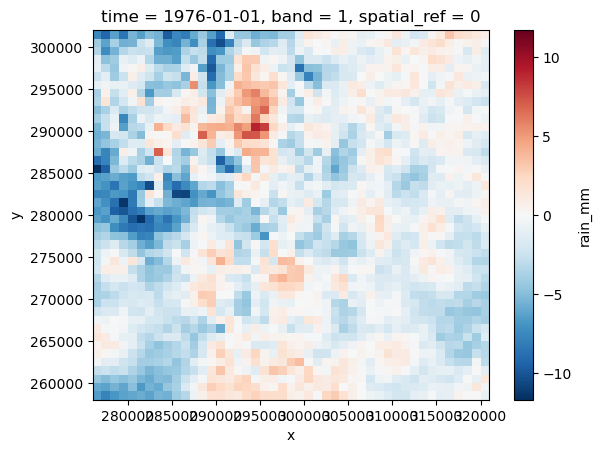

In [ ]:
ceh_haduk_diff.isel(time=0).plot()

# Examine distance to gauge

In [ ]:
changes_in_dist = ceh_plynlimon_shifted['min_dist'].diff(dim='time').sum(('x', 'y'))
change_dates = changes_in_dist.where(changes_in_dist != 0).dropna(dim='time')['time']
big_changes_dates = changes_in_dist.where(abs(changes_in_dist) > 500000).dropna(dim='time')['time']
big_changes_dates.time.size

74

In [ ]:
def get_gauge_metadata_on_date(date):
    plynlimon_gauges_on_date = plynlimon_all_gauges.filter(pl.col("time") == date)
    plyn_gauge_ids = plynlimon_gauges_on_date['gauge_id'].unique()
    plyn_metadata_on_date = plynlimon_metadata.filter(pl.col("ID").is_in(plyn_gauge_ids))
    return plyn_metadata_on_date

def plot_gauge_scatter(plyn_metadata_on_date, ax, marker='o'):
    for plyn_row in plyn_metadata_on_date.iter_rows(named=True):
        if plyn_row['IS_MONTHLY_GAUGE']:
            ax.scatter(plyn_row['EASTING'], plyn_row['NORTHING'], marker=marker, edgecolor='y', facecolor='None', linewidths=1.5,  alpha=.7)
        else:
            ax.scatter(plyn_row['EASTING'], plyn_row['NORTHING'], marker=marker, edgecolor='r', facecolor='None', linewidths=1.5, alpha=.8)
    return ax

In [ ]:
ceh_haduk_sum_diff = abs(ceh_haduk_diff).sum(('y', 'x'))
big_diff_times = ceh_haduk_sum_diff[ceh_haduk_sum_diff > 5000]['time']
len(big_diff_times)

146

In [ ]:
a = set((big_changes_dates + np.timedelta64(0, 'D')).data)
b = set((big_diff_times + np.timedelta64(0, 'D')).data)
a.intersection(b)

{np.datetime64('1992-06-01T00:00:00.000000000'),
 np.datetime64('1999-10-01T00:00:00.000000000')}

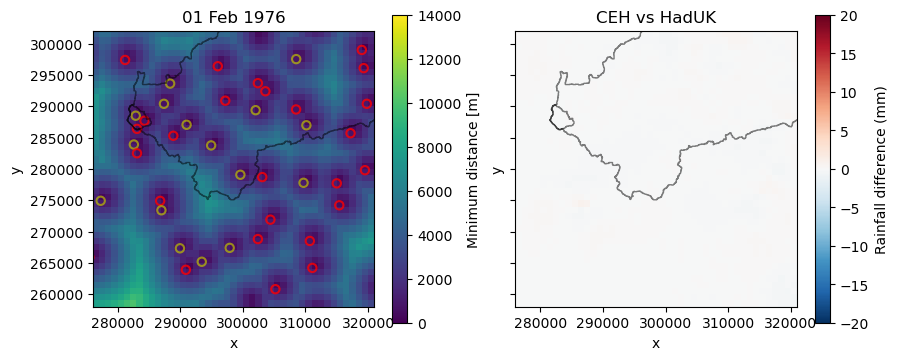

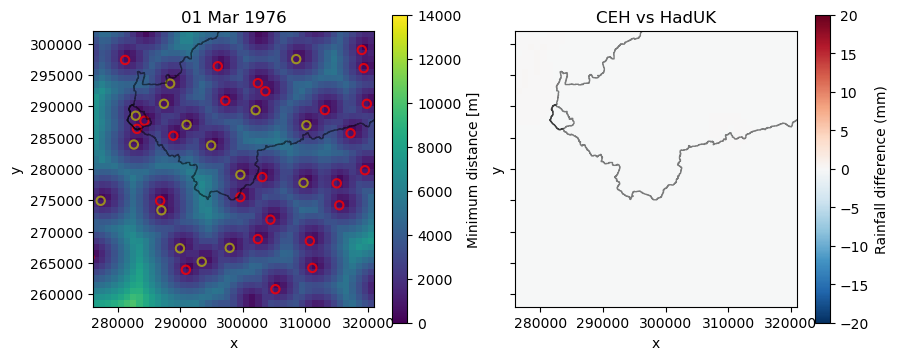

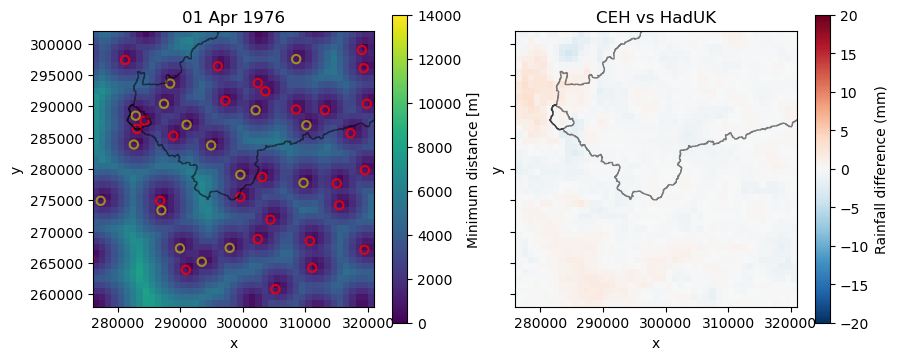

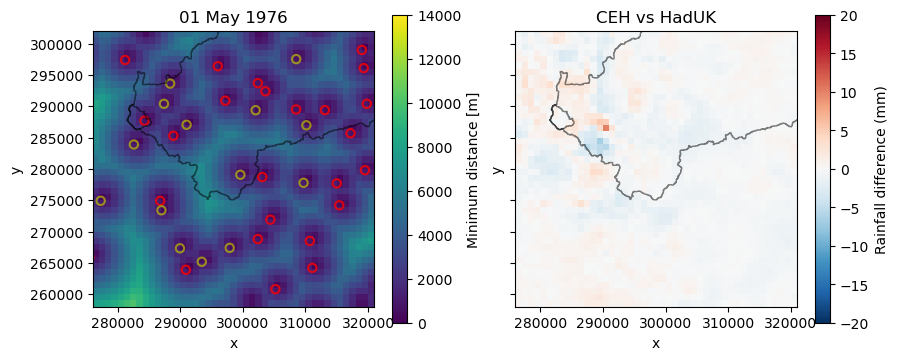

In [ ]:
for ind, change_date in enumerate(change_dates[:4]):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
    ceh_plynlimon_shifted['min_dist'].sel(time=change_date).plot(vmin=0, vmax=14000, ax=axes[0])
    axes[0].set_title(f"{change_date.dt.strftime("%d %b %Y").data}")
    plyn_metadata_on_date = get_gauge_metadata_on_date(change_date)
    axes[0] = plot_gauge_scatter(plyn_metadata_on_date, axes[0])
    ceh_haduk_diff.sel(time=change_date).plot(ax=axes[1], cmap='RdBu_r', vmin=-20, vmax=20, cbar_kwargs={'label':'Rainfall difference (mm)'})
    axes[1].set_title("CEH vs HadUK")
    for ax in axes:
        plynlimon_shp.plot(ax=ax, facecolor='none', alpha=.5)
        bewdley_shp.plot(ax=ax, facecolor='none', alpha=.5)
    # fig.savefig(f'../../min_dist_plynlimon_w_comparison/{ind}_min_dist_plyn_{change_date.dt.strftime("%d_%b_%Y").data}.png', bbox_inches='tight')
    # plt.close()
    plt.show()

# Look at annual changes in gauges

In [ ]:
ceh_haduk_diff_annual = ceh_haduk_diff.groupby('time.year').mean()

In [ ]:
def get_gauge_id_changes_in_dates(dates):
    added_ids_list = []
    dropped_ids_list = []
    added_but_removed = []
    for ind, date in enumerate(dates):
        gauge_metadata_on_date = get_gauge_metadata_on_date(date)
        if ind == 0:
            previous_gauge_ids = set(gauge_metadata_on_date['ID'])
            continue
        current_gauge_ids = set(gauge_metadata_on_date['ID'])
        added_ids = previous_gauge_ids - current_gauge_ids
        dropped_ids = current_gauge_ids - previous_gauge_ids
        added_ids_list += list(added_ids)
        dropped_ids_list += list(dropped_ids)

        ## Make note of IDs that have been dropped and added again or vice versa
        for add_id in added_ids:
            if add_id in dropped_ids_list:
                dropped_ids_list.remove(add_id)
        for drop_id in dropped_ids:
            if drop_id in added_ids_list:
                added_ids_list.remove(drop_id)
                added_but_removed.append(drop_id)

        previous_gauge_ids = current_gauge_ids
    added_but_removed = set(added_but_removed)
    dropped_ids = set(dropped_ids_list).difference(added_but_removed)
    return set(added_ids_list), dropped_ids, added_but_removed

In [ ]:
change_dates_that_year = change_dates.sel(time=change_dates.time.dt.year==2005)
added_ids, dropped_ids, added_but_removed = get_gauge_id_changes_in_dates(change_dates_that_year)

In [ ]:
print(f'Added IDs: {added_ids}\nDropped IDs: {dropped_ids}\nAdded then removed IDs: {added_but_removed}')

Added IDs: {423008, 467004}
Dropped IDs: {465397}
Added then removed IDs: {464225, 421090, 464676, 465260, 467004, 422328, 464924, 519357, 519358}


In [ ]:
gauge_metadata_on_date = get_gauge_metadata_on_date(change_dates_that_year[-1])
final_gauge_ids = set(gauge_metadata_on_date['ID'])
consistent_ids = final_gauge_ids.difference(dropped_ids).difference(added_ids).difference(added_but_removed)
consistent_ids

{420720, 420868, 420983, 421234, 421484, 422493, 422693, 464675, 465928}

In [ ]:
# Manually create legend handles
circle_legend = mlines.Line2D([], [], color='k', marker='o', linestyle='None', markersize=6, label="Gauge pre-existing")
square_legend = mlines.Line2D([], [], color='k', marker='s', linestyle='None', markersize=6, label="Gauge added")
star_legend = mlines.Line2D([], [], color='k', marker='*', linestyle='None', markersize=6, label="Gauge removed")
triangle_legend = mlines.Line2D([], [], color='k', marker='^', linestyle='None', markersize=6, label="Added then removed")


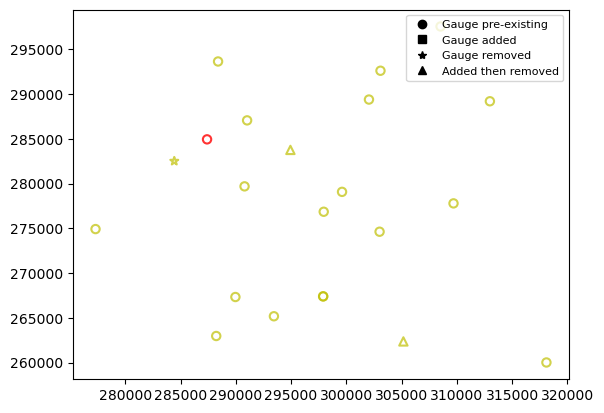

In [ ]:
fig, ax = plt.subplots(1)
for ids_set, marker_to_use in zip([consistent_ids, added_ids, dropped_ids, added_but_removed], ['o', 's', '*', '^']):
    plot_gauge_scatter(plynlimon_metadata.filter(pl.col("ID").is_in(ids_set)), ax, marker=marker_to_use)
ax.legend(handles=[circle_legend, square_legend, star_legend, triangle_legend], fontsize=8, loc='upper right')

In [ ]:
for year in ceh_haduk_diff_annual.year:
    year = int(year)
    fig, ax = plt.subplots(1, figsize=(7, 4))
    ceh_haduk_diff_annual.sel(year=year).plot(vmin=-1.8, vmax=1.8, cmap='RdBu_r', cbar_kwargs={'label': 'Mean rainfall difference (mm)'})

    change_dates_that_year = change_dates.sel(time=change_dates.time.dt.year==year)
    added_ids, dropped_ids, added_but_removed = get_gauge_id_changes_in_dates(change_dates_that_year)

    final_gauge_ids = set(get_gauge_metadata_on_date(change_dates_that_year[-1])['ID'])
    consistent_ids = final_gauge_ids.difference(dropped_ids).difference(added_ids).difference(added_but_removed)
    for ids_set, marker_to_use in zip([consistent_ids, added_ids, dropped_ids, added_but_removed], ['o', 's', '*', '^']):
        ax = plot_gauge_scatter(plynlimon_metadata.filter(pl.col("ID").is_in(ids_set)), ax=ax, marker=marker_to_use)
    ax.legend(handles=[circle_legend, square_legend, star_legend, triangle_legend], fontsize=8, loc='upper right')
    ax.set_title(f'CEH vs HadUK: {year}')
    plynlimon_shp.plot(ax=ax, facecolor='none', alpha=.5)
    bewdley_shp.plot(ax=ax, facecolor='none', alpha=.5)
    ax.set_xlabel(''); ax.set_ylabel('');
    # fig.savefig(f'../figures/ceh_vs_haduk_grid_gauge_changes/ceh_vs_haduk_grid_gauge_changes_{year}.png', bbox_inches='tight', dpi=200)
    # plt.close()
    # plt.show()

# Compare min dist and data differences

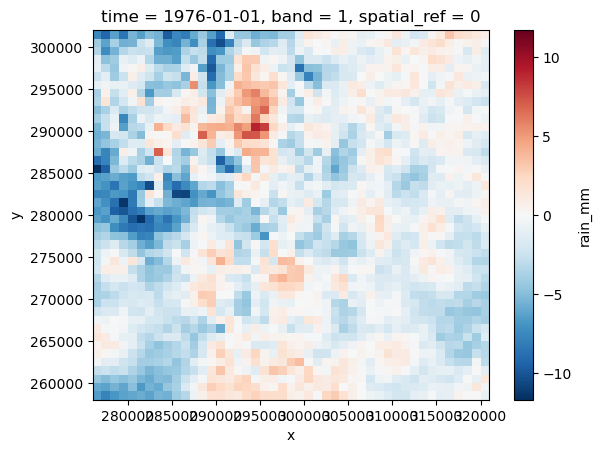

In [ ]:
ceh_haduk_diff.isel(time=0).plot()

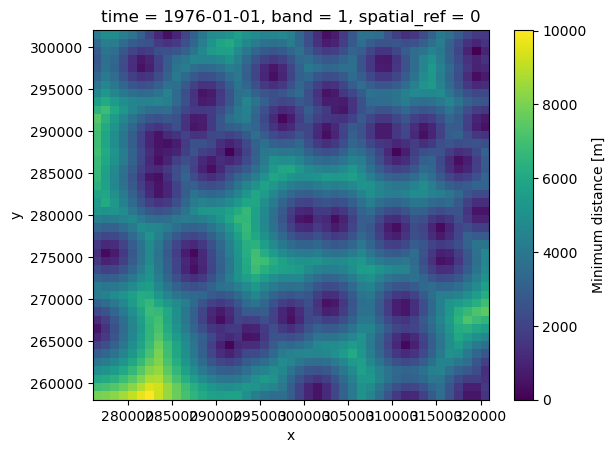

In [ ]:
ceh_plynlimon_shifted['min_dist'].isel(time=0).plot()

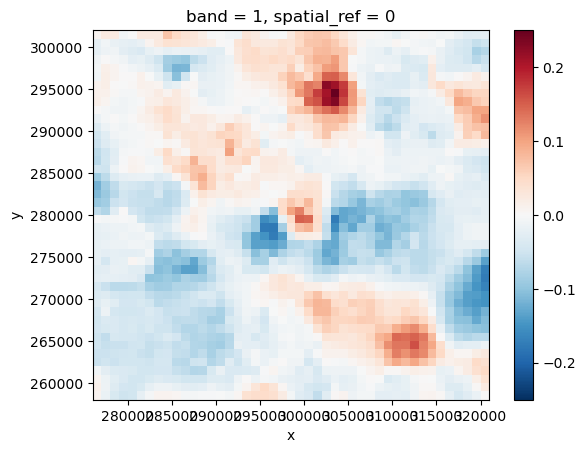

In [ ]:
ceh_plynlimon_shifted['norm_min_dist'] = (ceh_plynlimon_shifted['min_dist'] - ceh_plynlimon_shifted['min_dist'].min()) / (ceh_plynlimon_shifted['min_dist'].max() - ceh_plynlimon_shifted['min_dist'].min())

In [ ]:
ceh_haduk_diff_norm = (ceh_haduk_diff - ceh_haduk_diff.min()) / (ceh_haduk_diff.max() - ceh_haduk_diff.min())

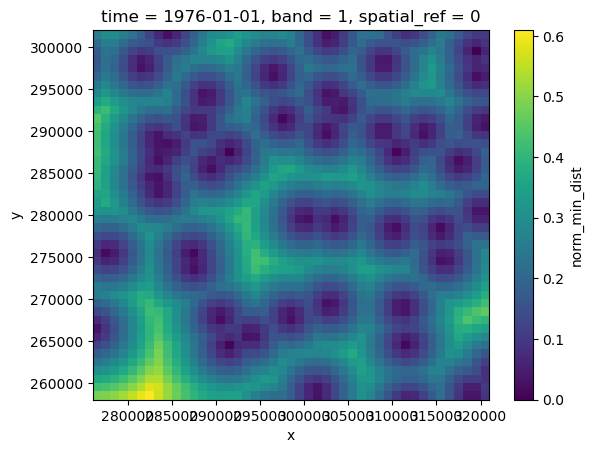

In [ ]:
ceh_plynlimon_shifted['norm_min_dist'].isel(time=0).plot()

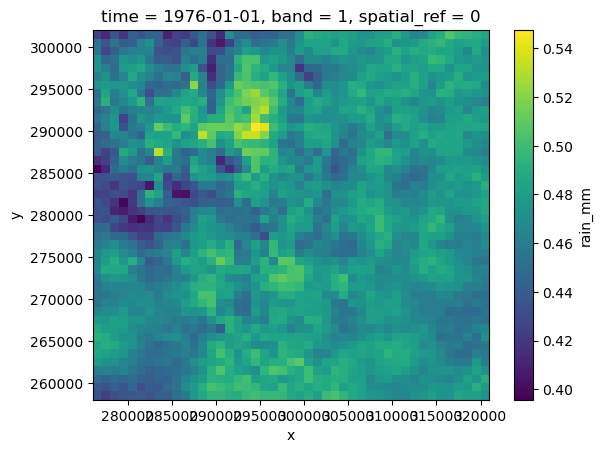

In [ ]:
ceh_haduk_diff_norm.isel(time=0).plot()

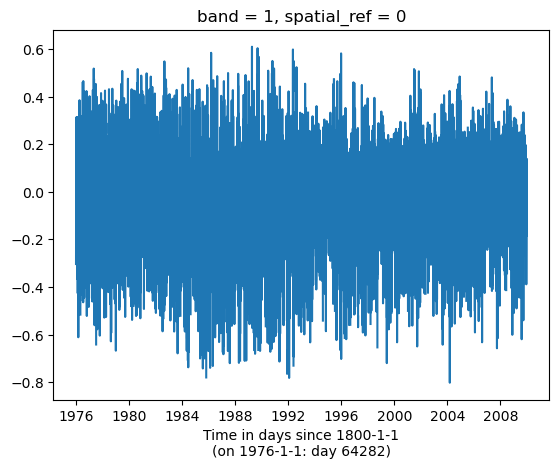

In [ ]:
xr.corr(ceh_plynlimon_shifted['min_dist'], ceh_haduk_diff, dim=('x', 'y')).plot()